# Пример использования библиотеки BigARTM для тематического моделирования

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [3]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [5]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1})
# число после названия модальностей - это их веса

In [6]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                           use_unigram_document_model=False,
                                           dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

Создаем словарь и инициализируем модель с его помощью

In [8]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [9]:
model_artm.initialize('dictionary')

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [11]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

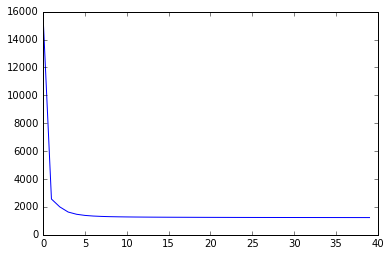

In [12]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [25]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

 sbj0:  право ребенок язык свобода семья английский религиозный гражданский быт суд воспитание честь орган the закреплять
sbj1:  жить повесть женщина нет поэма лермонтов написать школа молодой сказка отец хороший любить гоголь умирать
sbj2:  слово например предложение простой какой речь предмет глагол скорость физика имя выступать свет кто живой
sbj3:  земля энергия вода ядро масса движение природный состоять океан частица атом заряд температура располагать южный
sbj4:  пушкин поэт стихотворение звук лирика писать стих поэзия сравнение почти ночь русь былина красота любовный
sbj5:  при x a сила если два число можно b функция пример получать тело равный случай
sbj6:  человек его жизнь герой русский главный произведение мир литература сам история автор литературный личность всегда
sbj7:  общество представлять развитие отношение социальный политический процесс форма система экономический производство культура характер понятие роль
sbj8:  страна территория население город древний северный 

Давайте посмотрим также на разреженность матриц:

In [16]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.767712280266
0.00189075630252


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [18]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary="dictionary"))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [20]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Попробуем менять коэффициент регуляризации:

In [21]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [23]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [24]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    for word in model_artm.score_tracker["top_words"].last_topic_info[topic_name].tokens:
        print word,
    print

sbj0: 

AttributeError: 'TopTokensScoreTracker' object has no attribute 'last_topic_info'

In [ ]:
# еще раз посмотрим на разреженность
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [ ]:
model_artm.save("my_model")

In [ ]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [ ]:
phi = model_artm.get_phi()

In [ ]:
phi

Матрица вероятностей тем в документах.

In [ ]:
theta = model_artm.get_theta()
theta

Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [ ]:
theta_test = model_artm.transform(batch_vectorizer, num_document_passes=10)